In [1]:
# install pymongo if not installed

! pip install pymongo==3.11.3

In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# connect to local mongodb and database test
 
MONGO_HOST= 'mongodb://localhost:27017/test'

client = MongoClient(MONGO_HOST)

# select database
db=client['test']

#select the collection within the database
collection = db.climate_change

In [2]:
# disply first document in the collection
result=collection.find()
result[0]['author']

{'created_at': '2009-03-12T05:18:41.000Z',
 'description': 'Canadiense pero nacido en venezuela y venezolano de corazon. Love all kind of sports . Great travel consultant. Canucks,whitecaps, lions and man u biggest fan',
 'id': '23903376',
 'location': 'vancouver bc canada',
 'name': 'thomas marino',
 'profile_image_url': 'https://pbs.twimg.com/profile_images/654484790536593408/zItRQAIL_normal.jpg',
 'protected': False,
 'public_metrics': {'followers_count': 1838,
  'following_count': 5002,
  'tweet_count': 858106,
  'listed_count': 182},
 'username': 'thomasmarinojr',
 'verified': False}

# conduct a text search

Need to create an index first in Visual studio code


In [3]:
# display top 5 tweets (based on the score of relevence) that mention health problem, not covid
pipeline= [
    {"$match": {"$text": 
        {"$search": "\"health problem\" -covid"}
    }},
    {"$addFields": {"score": {"$meta": "textScore"}}},
    {"$sort": {"score":-1}},
    {"$limit": 5},
    {"$project":{
        "text":1,
        "score":1,
        "created_at":1,
        "_id":0
    }
    }
]

result=collection.aggregate(pipeline)

for res in result:
    print(res)

{'created_at': '2023-02-23T03:23:50.000Z', 'text': 'RT @todongpnoy: Join EV revolution and eliminate ICE that emits poisonous gases and killed millions of lives and health problems around the…', 'score': 1.0625}
{'created_at': '2023-02-22T21:35:41.000Z', 'text': 'RT @todongpnoy: Join EV revolution and eliminate ICE that emits poisonous gases and killed millions of lives and health problems around the…', 'score': 1.0625}
{'created_at': '2023-02-23T20:48:19.000Z', 'text': 'RT @AVERE_EU: 🔋 #EVs are cutting pollution levels and reducing health problems. A new study by @KECKSchool_USC of @USC confirms yet again t…', 'score': 1.0588235294117647}
{'created_at': '2023-02-23T18:10:46.000Z', 'text': '@whstancil about the potential environmental and health problems in Ohio. Well, it\'s probably going to happen. There\'s probably going to be more cancer now. And what we get from a lot of supposedly progressive folks is, "nbd." That\'s a little messed up imho.', 'score': 1.0434782608695652}
{'creat

## Top Users

In [4]:
# find top 10 users based on number of tweets in this topic.

pipeline =[
  {"$group": {
    "_id": "$author.username",
    "numTweets": {"$sum":1}
  }
  },
  {"$sort": {"numTweets": -1}},
  {"$limit": 10}, 
  {"$project":{
        "userName": "$_id",
        "numTweets":1,
        "_id":0}
   }
]

result=collection.aggregate(pipeline)

result_list=[res for res in result]  # create an array to store the result

# convert result into pandas

result_pd = pd.DataFrame(result_list)

result_pd.head()

,numTweets,userName
0,379,Sandeep4Earth
1,377,mh4829799
2,288,kroy133
3,215,climateline
4,144,duwisyahlevi1


## [Choose a color palettes in seaborn](https://seaborn.pydata.org/tutorial/color_palettes.html)

<AxesSubplot:xlabel='numTweets', ylabel='userName'>

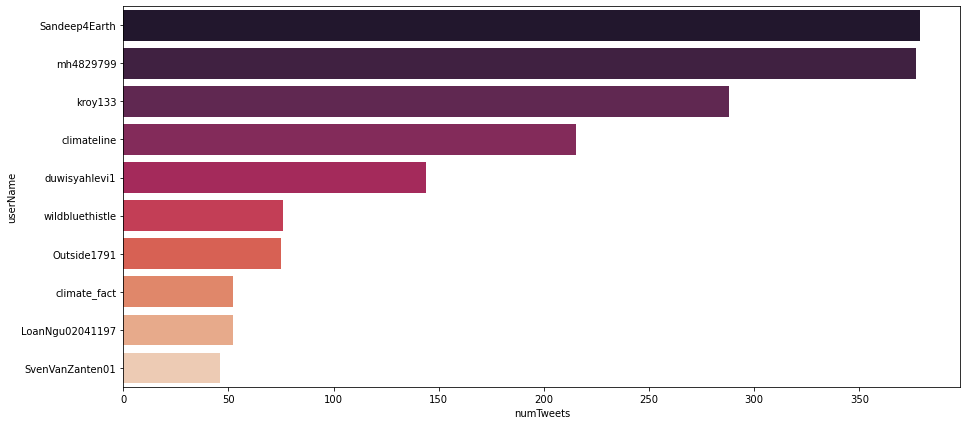

In [7]:
# visualize the result

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 10 variations
palette=sns.color_palette("rocket", 10)

# plot a bar chart
sns.barplot(
    x="numTweets", 
    y="userName", 
    data=result_pd, 
    palette=palette)

In [34]:
# define a function to return top N users based on number of tweets
def topNUsers(n):
    
    pipeline =[
      {"$group": {
    "_id": "$author.username",
    "numTweets": {"$sum":1}
      }
      },
      {"$sort": {"numTweets": -1}},
      {"$limit": n},
      {"$project":{
        "userName": "$_id",
        "numTweets":1,
        "_id":0    }
     }
    ]

    result=collection.aggregate(pipeline)
     
    result_pd = pd.DataFrame(res for res in result)
   
    return result_pd

<AxesSubplot:xlabel='numTweets', ylabel='userName'>

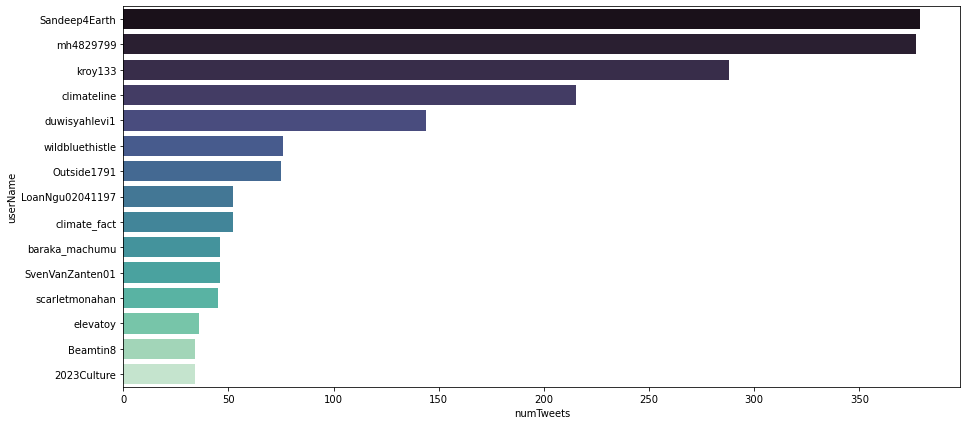

In [35]:
result_pd=topNUsers(15)

# visualize the result

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 15 variations
palette=sns.color_palette("mako", 15)

# plot a bar chart
sns.barplot(
    x="numTweets", 
    y="userName", 
    data=result_pd, 
    palette=palette)

## Number of followers for top users

In [36]:
pipeline =[
  {"$group": {
    "_id": "$author.username",
    "numTweets": {"$sum":1},
    "user_info":{"$push":{"followers_count":"$author.public_metrics.followers_count", 
                         "following_count": "$author.public_metrics.following_count"}}
  }
  },
  {"$sort": {"numTweets": -1}},
  {"$limit": 10},
  {"$project": {
    "user_name": "$_id",
    "numTweets":1,
    "followers_count": {"$max": "$user_info.followers_count"},
    "following_count": {"$max": "$user_info.following_count"},
    "_id":0
  }}
]

result=collection.aggregate(pipeline)

result_list=[res for res in result] 

result_pd = pd.DataFrame(result_list)

result_pd.head()

,numTweets,user_name,followers_count,following_count
0,379,Sandeep4Earth,12268,90
1,377,mh4829799,6,32
2,288,kroy133,39,3
3,215,climateline,30,120
4,144,duwisyahlevi1,19,369


## Create a combination chart

Text(0, 0.5, 'Followers Count')

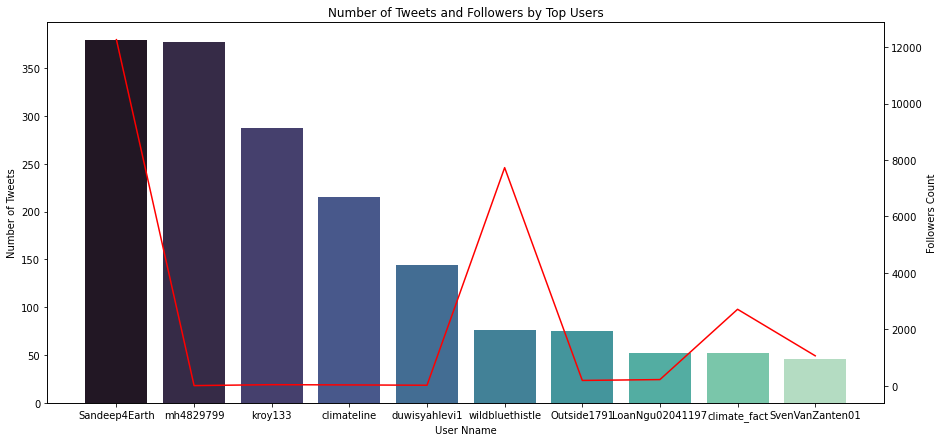

In [33]:
# Set the figure size

plt.figure(figsize=(15, 7))

# use a sequential color with 10 variations
palette=sns.color_palette("mako", 10)

# create a bar chart using seaborn

ax=sns.barplot(x="user_name", y="numTweets", data=result_pd, palette=palette)

# create a line chart using seaborn and Matplotlib

ax2=ax.twinx()

ax2.plot(result_pd["user_name"], result_pd["followers_count"], color="red")

# set the chart title and labels
ax.set_title("Number of Tweets and Followers by Top Users")
ax.set_xlabel("User Nname")
ax.set_ylabel("Number of Tweets")
ax2.set_ylabel("Followers Count")

# Top annotation in the text

In [37]:
# display top annotation mentioned in the text

# type can be place, organization, person, product and other

def topNAnnotation(topN=10, type='place'):
    pipeline =[
    {"$unwind": "$entities.annotations"},
    {"$addFields": {"type": {"$toLower": "$entities.annotations.type"}}},
    {"$addFields": {"normalized_text": {"$toLower": "$entities.annotations.normalized_text"}}},
    {"$group": {
        "_id": {"type": "$type"},
        "entity_list": {"$push":"$normalized_text"}
    }},
    {"$match": {"_id.type": type}},
    {"$unwind": "$entity_list"},
    {"$group":{
        "_id":"$entity_list",
        "frequency": {"$sum":1}
    }},
    {"$sort": {"frequency":-1}},
    {"$limit":topN}]
    
    result=collection.aggregate(pipeline)

    result_list=[]  # create am array to store the result

    result_pd = pd.DataFrame(res for res in result)
    
    return result_pd

In [38]:
types=['place', 'organization', 'person', 'product', 'other']

# create an empty pandas
total_df = pd.DataFrame()

for type in types:
    topN=topNAnnotation(10, type)
    topN['type']=type
    total_df=pd.concat([total_df, topN], axis=0) 

[Text(0.5, 0, 'Number of Tweets'),
 Text(0, 0.5, 'Place'),
 Text(0.5, 1.0, 'Top Places Mentioned in Tweets')]

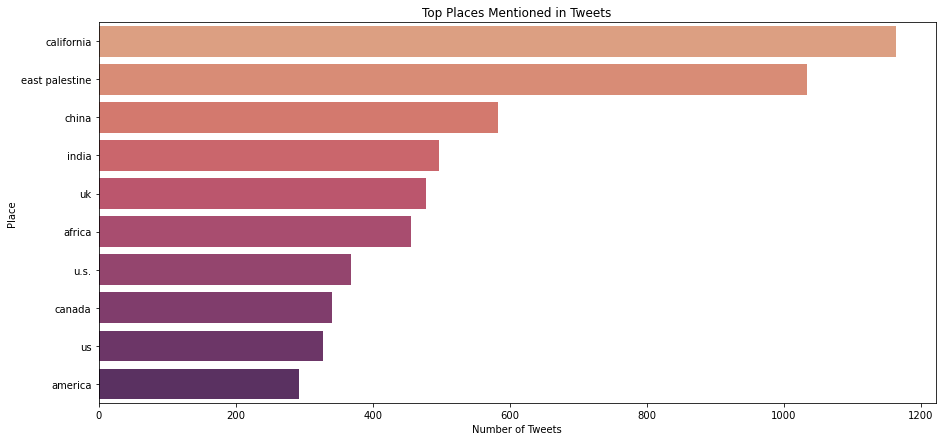

In [39]:
# visualize the result

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 10 variations
palette=sns.color_palette("flare", 10)

# plot a bar chart
ax=sns.barplot(
    x="frequency", 
    y="_id", 
    data=total_df[total_df.type=='place'], 
    palette=palette)

ax.set(xlabel="Number of Tweets", ylabel="Place", title="Top Places Mentioned in Tweets")

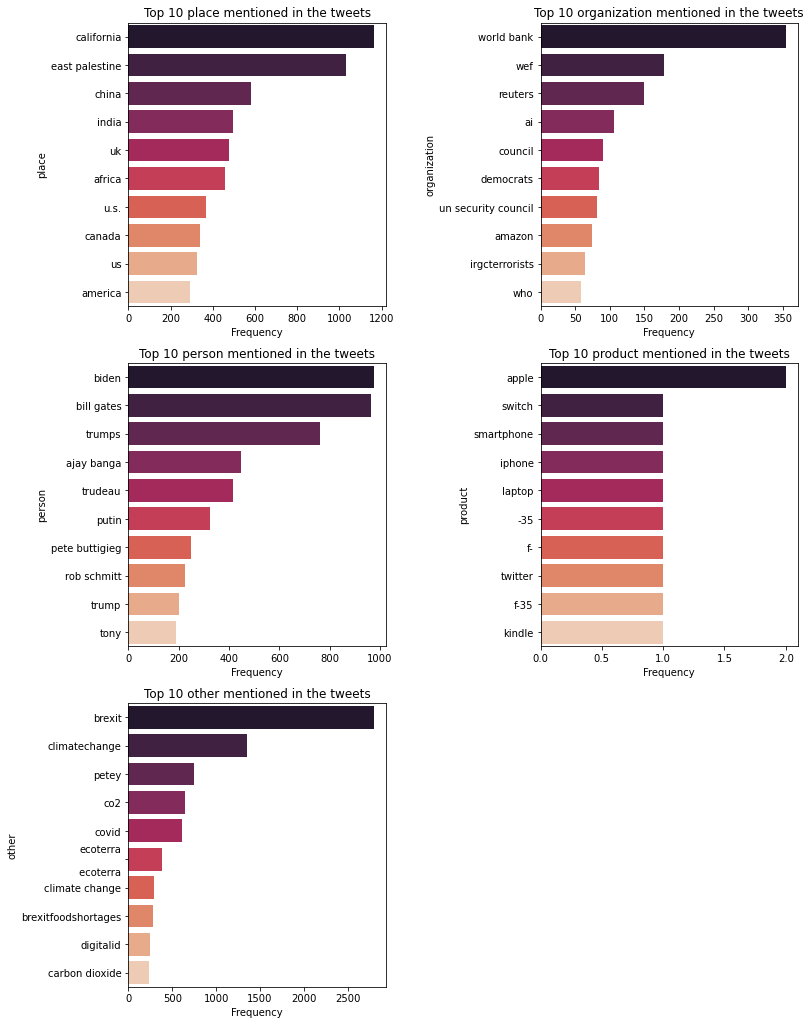

In [40]:
import matplotlib.pyplot as plt
i=1


fig = plt.figure(figsize=(12,24)) # define the size of the figure
fig.subplots_adjust(hspace=0.2, wspace=0.6)  #adjust the spacing between the plots

types=['place', 'organization', 'person', 'product', 'other']

for type in types:
    
    plt.subplot(4,2,i)   #create a 4 by 2 subplot 
   
    data=total_df[total_df.type==type]
    
    # use a sequential color with 10 variations
    palette=sns.color_palette("rocket", 10)

    # plot a bar chart
    sns.barplot( x="frequency", 
    y="_id", 
    data=data, 
    palette=palette)
    
    # add label
    plt.xlabel('Frequency')
    plt.ylabel(type)
    plt.title("Top 10 "+type+ " mentioned in the tweets")
    i=i+1

## Top Hashtags

In [18]:
# display top N hashtags

def topNHashtags(n):
    
    pipeline =[
    {"$unwind": "$entities.hashtags"},
    {"$addFields": {"hashtags": {"$toLower": "$entities.hashtags.tag"}}},
    {"$match": {"hashtags": {"$nin": ["climate", "climatechange", "climatechangeisreal", "globalwarming"]}}},
    {"$group": {
        "_id": {"hashtag": "$hashtags"},
        "frequency": {"$sum":1}
    }},
    {"$sort": {"frequency":-1}},
    {"$limit":n},
    {"$project":{
        "hashtag": "$_id.hashtag",
        "frequency":1,
        "_id":0    }
    }
    ]
    
    result=collection.aggregate(pipeline)

    result_pd = pd.DataFrame(res for res in result)
    
    return result_pd

In [19]:
top10hashtags=topNHashtags(10)

top10hashtags

,frequency,hashtag
0,592,climatecrisis
1,526,climateaction
2,348,climateemergency
3,313,sustainability
4,284,brexitfoodshortages
5,262,environment
6,258,digitalid
7,251,news
8,215,climateline
9,209,5irethunder


<AxesSubplot:xlabel='frequency', ylabel='hashtag'>

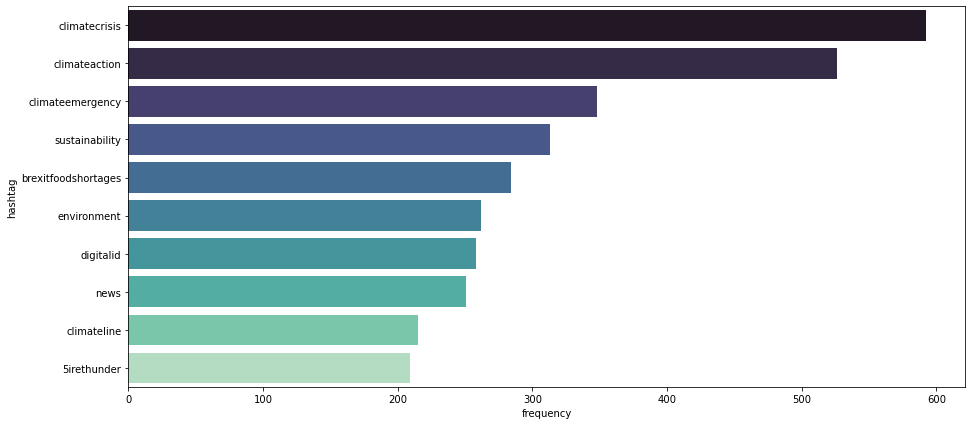

In [20]:
# visualize the result

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 10 variations
palette=sns.color_palette("mako", 10)

# plot a bar chart
sns.barplot(
    x="frequency", 
    y="hashtag", 
    data=top10hashtags, 
    palette=palette)

In [21]:
# top N hashtags by weekday

def topNHashtagsByWeekday(n):
    pipeline=[
    {"$addFields": {"weekday": {"$dayOfWeek": {"$toDate": "$created_at"}}}},
    {"$unwind": "$entities.hashtags"},
    {"$addFields": {"hashtags": {"$toLower": "$entities.hashtags.tag"}}},
    {"$match": {"hashtags": {"$nin": ["climatechange", "climate", "climatechangeisreal", "globalwarming"]}}},
    {"$group": {
        "_id": {"weekday": "$weekday", "hashtag":"$hashtags"},
        "frequency": {"$sum":1}
    }},
    {"$sort": {"frequency":-1}},
    {"$group":{
        "_id": "$_id.weekday",
        "hashtags": {"$push": {"hashtag": "$_id.hashtag", "frequency": "$frequency"}}
    }},
    {"$sort": {"_id.weekday":1}},
    {"$project":{
        "top10Hashtags": {"$slice":["$hashtags", 0, n]}
    }},
    {"$unwind": "$top10Hashtags"},
    {"$project":{
        "weekday": "$_id",
        "hashtag": "$top10Hashtags.hashtag",
       "frequency": "$top10Hashtags.frequency",
        "_id":0
    }}    
   ]

    result=collection.aggregate(pipeline)

    result_pd = pd.DataFrame(res for res in result)
    
    return result_pd

In [22]:
result_pd=topNHashtagsByWeekday(10)
result_pd

,weekday,hashtag,frequency
0,5,climatecrisis,484
1,5,climateaction,449
2,5,climateemergency,272
3,5,sustainability,251
4,5,environment,222
5,5,5irethunder,173
6,5,news,169
7,5,cleangreensindh,168
8,5,energy,152
9,5,solar,141


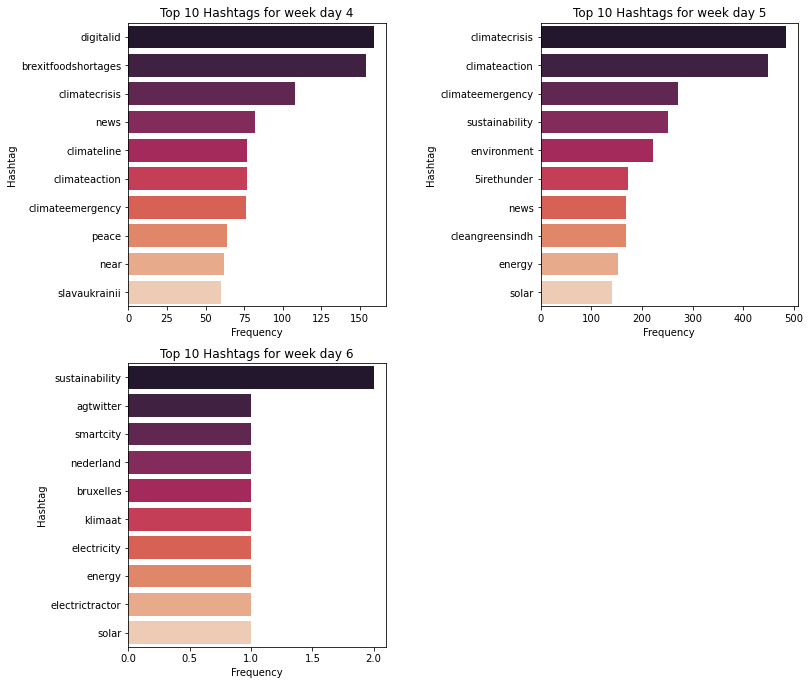

In [23]:
import matplotlib.pyplot as plt
i=1
numWeekdays=result_pd.weekday.unique() #find the unique week days in the result
numWeekdays.sort() #sort the week day by ascending order

fig = plt.figure(figsize=(12,24)) # define the size of the figure
fig.subplots_adjust(hspace=0.2, wspace=0.6)  #adjust the spacing between the plots

for weekday in numWeekdays:
    plt.subplot(4,2,i)   #create a 4 by 2 subplot 
    weekdayResult_pd=result_pd[result_pd["weekday"]==weekday]
    
    # use a sequential color with 10 variations
    palette=sns.color_palette("rocket", 10)

    # plot a bar chart
    sns.barplot( x="frequency", 
    y="hashtag", 
    data=weekdayResult_pd, 
    palette=palette)
    
    # add label
    plt.xlabel('Frequency')
    plt.ylabel("Hashtag")
    plt.title("Top 10 Hashtags for week day "+str(weekday))
    i=i+1

In [24]:
top100hashtags=topNHashtags(100)

top100hashtags

,frequency,hashtag
0,592,climatecrisis
1,526,climateaction
2,348,climateemergency
3,313,sustainability
4,284,brexitfoodshortages
...,...,...
95,35,mahsaamini
96,34,tesla
97,34,innovation
98,33,weather


## Visualize top hashtags

In [76]:
# install wordcloud

!pip install wordcloud

In [27]:
# pick top 100 words and convert the result into a dictionary

tophashtags=topNHashtags(100)

result_dict=dict(zip(tophashtags["hashtag"], tophashtags['frequency']))

#result_dict

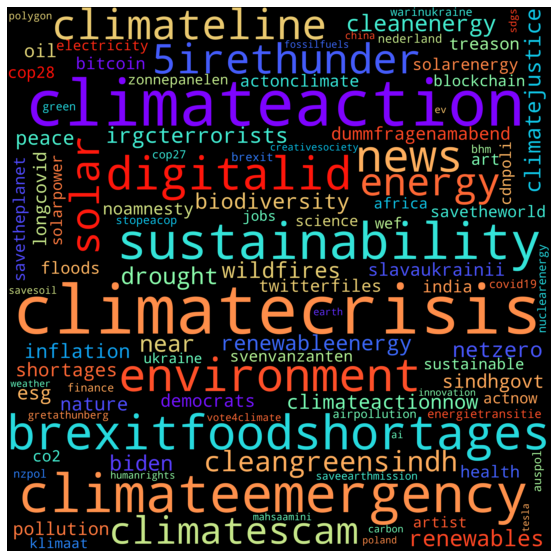

In [28]:
from wordcloud import WordCloud
from PIL import Image

# create the WordCloud object

wordcloud = WordCloud(width=3500,height=3500,normalize_plurals=True, background_color='black',colormap='rainbow')

# generate the word cloud
wordcloud.generate_from_frequencies(result_dict)

#plot
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Create word cloud based on most frequent words

In [29]:
# import stopwords

import nltk
from nltk.corpus import stopwords

stopwords=stopwords.words('english')

In [30]:
# create a function to show top N words by certain key words
def topNWordsByKeyWord(n, keyword, additionStopWords=[]):
    
    pipeline=[
    #{"$limit":10000},
    {"$match": {"lang": {"$eq": "en"}}},  # limit language to english
    {"$addFields": {"textArray":{"$toLower": "$text"}}},  # change to all lower cases
    {"$match": {"textArray": {"$regex": keyword}}},       # limit to the texts that mentions keyword
    {"$addFields": {"textArray": {"$split": ["$textArray", " "]}}},  # split the word into array
    {"$unwind": "$textArray"},                                       #explode array of words into word
    {"$addFields": {"words":{"$trim": {"input":"$textArray"}}}},
    {"$match": {"words": {"$not": {"$regex":"^#"}}}},
    {"$match": {"words": {"$not": {"$regex": "^@"}}}},
    {"$match": {"words": {"$not": {"$regex":"^http"}}}},
   # {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": "/[^a-z0-9]/g", "replacement": ""}}}},
    {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": ",", "replacement": ""}}}},
    {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": ":", "replacement": ""}}}},
    {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": ".", "replacement": ""}}}},
    {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": "-", "replacement": ""}}}},
    {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": "…", "replacement": ""}}}},
    {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": "&", "replacement": ""}}}},
    {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": "'s", "replacement": ""}}}},
    {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": "'", "replacement": ""}}}},
    {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": ";", "replacement": ""}}}},
    {"$addFields": {"words": {"$replaceAll": {"input": "$words", "find": "?", "replacement": ""}}}},
    {"$match": {"words": {"$nin": ["rt", "", "de", 'amp', "climate", "change", keyword]}}},
    {"$match": {"words": {"$nin":stopwords}}},
     {"$match": {"words": {"$nin":additionStopWords}}},
    {"$group": {
        "_id": "$words",
        "frequency": {"$sum":1}
    }},
    {"$sort": {"frequency":-1}},
    {"$limit":n},
    {"$project":{
        "word": "$_id",
        "frequency":1,
        "_id":0    }
    }
    ]

    result=collection.aggregate(pipeline)

    result_pd = pd.DataFrame(res for res in result)
    
    return result_pd

In [156]:
result_pd=topNWordsByKeyWord(100, "pollution", additionStopWords=['air', 'among'])
result_pd

,frequency,word
0,49,major
1,40,energy
2,32,solves
3,32,technologies
4,32,crises\n
...,...,...
95,8,land
96,8,reducing
97,8,injury
98,8,shown


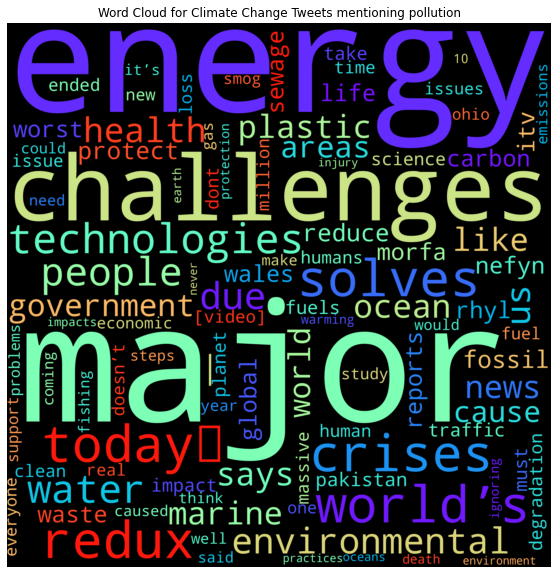

In [31]:
# Word Cloud mentioning pollution

result_pd=topNWordsByKeyWord(100, "pollution", additionStopWords=['air', 'among'])

result_dict=dict(zip(result_pd["word"], result_pd['frequency']))

from wordcloud import WordCloud
from PIL import Image

# create the WordCloud object

wordcloud = WordCloud(width=3500,height=3500,normalize_plurals=False, background_color='black',colormap='rainbow')

# generate the word cloud
wordcloud.generate_from_frequencies(result_dict)

#plot
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Climate Change Tweets mentioning pollution")
plt.axis('off')
plt.show()

<Figure size 864x864 with 0 Axes>

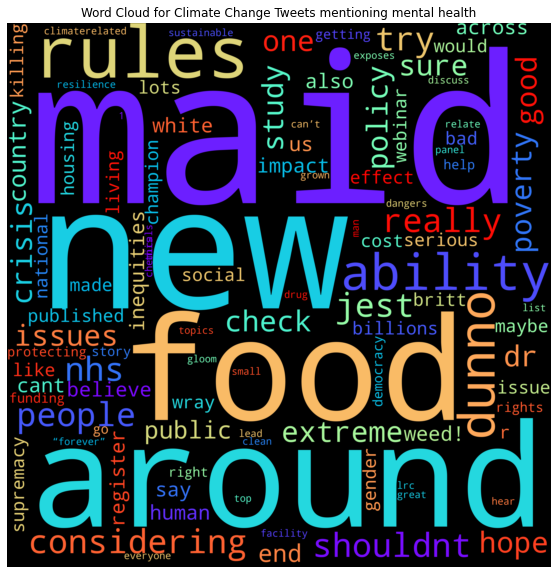

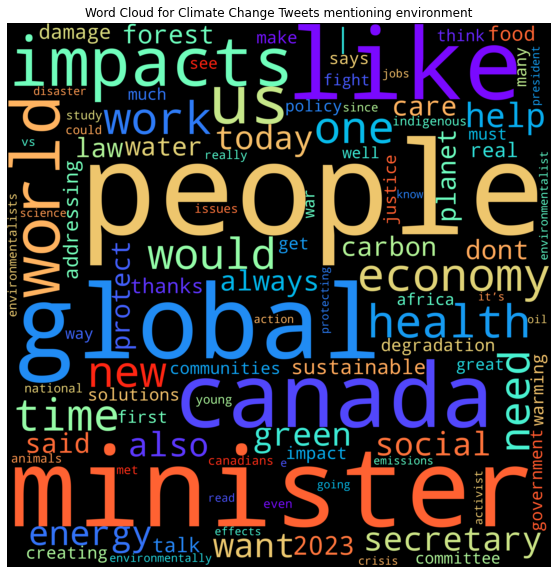

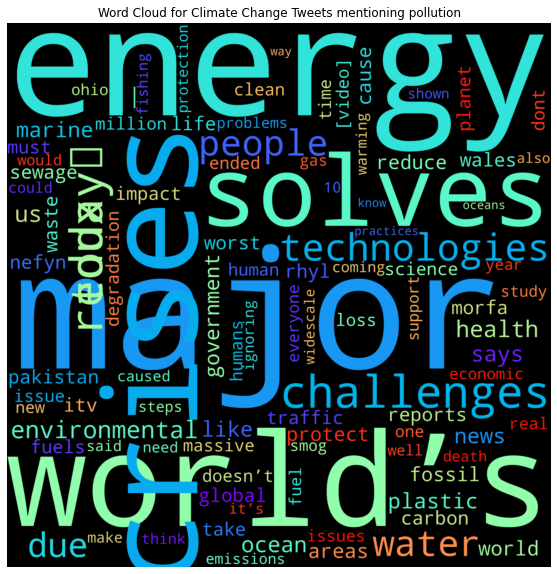

In [32]:
# Word Cloud comparing a few key words:
from wordcloud import WordCloud
from PIL import Image

keywords=['mental health', 'environment', 'pollution']

additionalStopWords=[['mental', 'health', 'environmental'], ['environmental'], ['air', 'among']]

result_dict_list=[]

i=0

for keyword in keywords:
    result_pd=topNWordsByKeyWord(100, keyword, additionalStopWords[i])
    i=i+1
    result_dict=dict(zip(result_pd["word"], result_pd['frequency']))
    result_dict_list.append(result_dict)
   

# create the WordCloud object
# create the WordCloud object

wordcloud = WordCloud(width=3500,height=3500,normalize_plurals=False, background_color='black',colormap='rainbow')


fig = plt.figure(figsize=(12,12)) # define the size of the figure
fig.subplots_adjust(hspace=0.2, wspace=0.6)  #adjust the spacing between the plots

j=0
for keyword in keywords:
    #plt.subplot(2,2,j+1)   #create a 4 by 2 subplot 
    wordcloud.generate_from_frequencies(result_dict_list[j])
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Word Cloud for Climate Change Tweets mentioning "+keyword)
    plt.axis('off')
    plt.show()
    j=j+1